# BONUS. The idea behind SVDLog

In [7]:
import embedded_voting as ev
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
np.random.seed(42)

In this notebook we are working again on the problem of algorithms aggregations. This time, we want to see why we can need sometimes the **SVDLog** rule, instead of **SVDNash**. For that, we will compare the different rules based on SVD.

In [8]:
list_rules = [ev.SVDNash(), ev.SVDSum(), ev.SVDLog()]

list_names = ["SVDNash", "SVDSum", "SVDLog"]

We create a score generator with $4$ dimensions and $5$ mixed groups

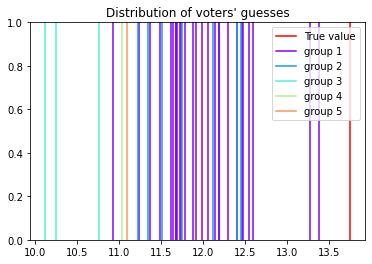

In [9]:
groups_sizes = [27, 7, 3, 1, 1]
features = [[1, 0, 0,0], [0, 1, 0,1], [1, 0, 1,0], [0, 1, 1,0], [0, 0, 1,1]]

generator = ev.GroupedMixGenerator(groups_sizes, features)
generator.set_group_noise(10)
generator.set_independent_noise(0.5)
generator.plot_scores()

In [10]:
n_voters = int(np.sum(groups_sizes))
n_candidates = 20

## Evolution with the number of dimensions

What we are doing here is that we are changing the number of dimensions used in the **AutoProfile**.

Indeed, if you use $n_{dim} = 0$, the profile automatically infer the number of dimensions with *scikit-learn*, but you can also specify the number of dimension. If you need to that, you might know that **SVDNash** and other rules do note perform the same depending on the number of dimensions used.

In [11]:
def dim_evolution(training_size=100):
    results = []
    
    dims = np.arange(1,21)
    for dim in dims:
            
        truth, scores = generator.sample_scores(20)
        _, training = generator.sample_scores(training_size)

        # We get the real welfare of each candidate using a SumScoresProfile 
        true_profile = ev.Profile(n_candidates, 0)
        true_profile.add_voter([], truth)
        target = ev.SumScores(true_profile)
        welfare = target.welfare_

        # We create the profile of voters-algorithms
        profile = ev.AutoProfile(n_candidates, 0)
        profile.add_voters_auto(scores, training, n_dim=dim)

        # We get the preformance of every rule
        results_i = []
        for rule in list_rules:
            w = rule(profile).winner_
            results_i.append(welfare[w])

        results.append(results_i)

    results = np.array(results).T
    return results

In [12]:
results = np.zeros((len(list_rules), 20))

n_trys = 500
for i in tqdm(range(n_trys)):
    results += dim_evolution()

results = results/n_trys

100%|██████████| 500/500 [06:28<00:00,  1.29it/s]


As you can see on the following figure, **SVDNash** works well when the correct number of dimension is inferred (here $4$), with a small margin of error. But, if the number of dimensions used is higher ($> 10$ for instance), then **SVDNash** is not as efficient, and its welfare is close to the welfare of **SVDSum**. However, **SVDLog**'s welfare is still as high as before.

In summary, **SVDLog** is a bit less good when we have the correct number of dimension, but it's performance is stable when the number of dimensions change!

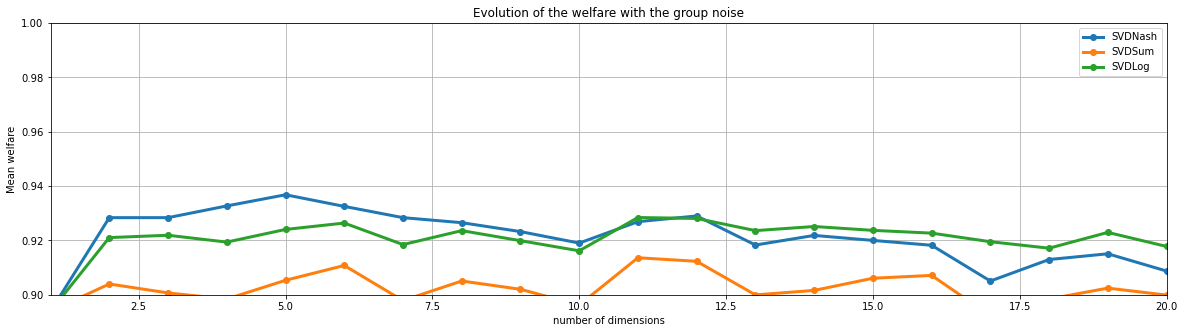

In [13]:
tab_dims = np.arange(1,21)

fig = plt.figure(figsize=(20, 5))

for i, r in enumerate(results):
    plt.plot(tab_dims, r, 'o-', label=list_names[i], linewidth=3)
    
plt.ylim(0.9, 1)
plt.xlim(1,20)
plt.legend()
plt.xlabel("number of dimensions")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with the group noise")
plt.grid(0.3)
plt.legend()
plt.show()

## What happen if we take the full matrix of covariance?

Let's compare what we got if we do not use PCA at all and directly use the covariance matrix, which is more elegant.

In [14]:
def best_method(training_size=100):
    results = []
               
    truth, scores = generator.sample_scores(20)
    _, training = generator.sample_scores(training_size)

    # We get the real welfare of each candidate using a SumScoresProfile 
    true_profile = ev.Profile(n_candidates, 0)
    true_profile.add_voter([], truth)
    target = ev.SumScores(true_profile)
    welfare = target.welfare_

    results = np.zeros((2, len(list_rules)))
    
    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_cov(scores, training, normalize_score=True)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[0,i] = welfare[w]

    # We create the profile of voters-algorithms
    profile = ev.AutoProfile(n_candidates, 0)
    profile.add_voters_auto(scores, training, normalize_score=True)

    # We get the preformance of every rule
    for i, rule in enumerate(list_rules):
        w = rule(profile).winner_
        results[1,i] = welfare[w]
        
    return results

In [19]:
results = np.zeros((2, len(list_rules)))

n_trys = 1000
for _ in tqdm(range(n_trys)):
    results += best_method()

results /= n_trys

100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]


As you can see in the following table, **SVDLog** performs better than the other rules with the full matrix. However, for any rule, doing the **PCA** is far better than using the full matrix.

In [20]:
pd.DataFrame(results, columns=list_names, index=["full cov", "pca"])

,SVDNash,SVDSum,SVDLog
full cov,0.893231,0.878854,0.909012
pca,0.938163,0.898214,0.923596
